## Import libraries

In [1]:
import os
import numpy as np
import zipfile
import random
import shutil
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
from shutil import copyfile
from PIL import Image

## Read Input

In [2]:
base_dir = "input/rice_plant_lacks_nutrients"

potassium_dir = os.path.join(base_dir, 'Potassium')
nitrogen_dir = os.path.join(base_dir, 'Nitrogen')
phosphorus_dir = os.path.join(base_dir, 'Phosphorus')

potassium_files = os.listdir(potassium_dir)
nitrogen_files =  os.listdir(nitrogen_dir)
phosphorus_files = os.listdir(phosphorus_dir)

print("Potassium images:", len(potassium_files))
print("Nitrogen images:", len(nitrogen_files))
print("Phosporus images:", len(phosphorus_files))

Potassium images: 383
Nitrogen images: 440
Phosporus images: 333


## Create dataset

In [3]:
BATCH_SIZE = 16
IMG_SIZE = (224, 224)
IMG_SHAPE = IMG_SIZE + (3,)

In [4]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    base_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

Found 1156 files belonging to 3 classes.
Using 925 files for training.


In [5]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    base_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

Found 1156 files belonging to 3 classes.
Using 231 files for validation.


In [6]:
val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take(val_batches // 5)
val_ds = val_ds.skip(val_batches // 5)

In [7]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(val_ds))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_ds))

Number of validation batches: 12
Number of test batches: 3


In [8]:
class_names = train_ds.class_names
print(class_names)

['Nitrogen', 'Phosphorus', 'Potassium']


## Visualize the input

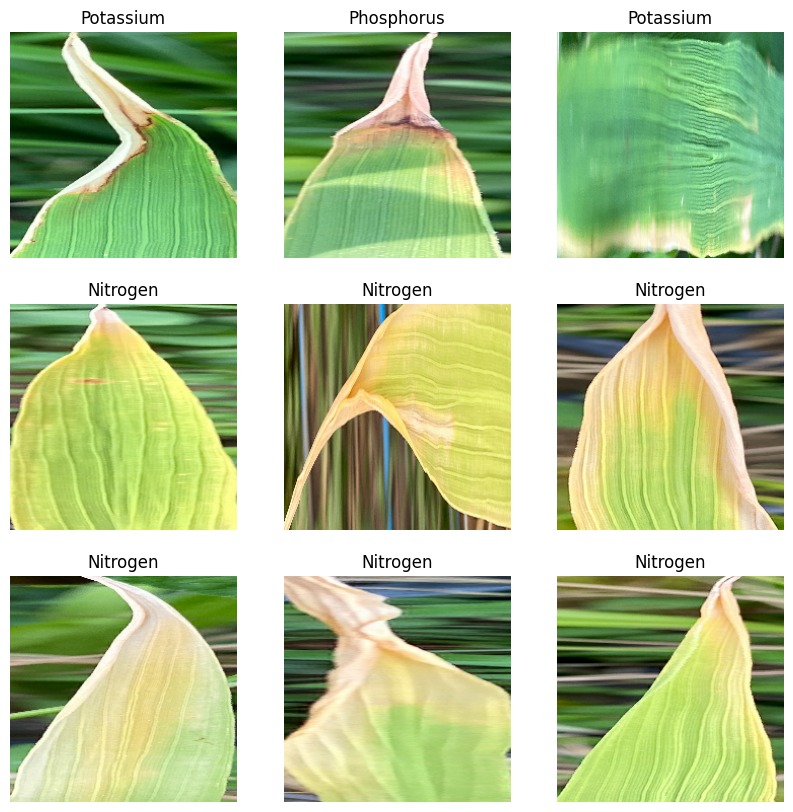

In [9]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

## Configure dataset

In [10]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

## Data Augmentation and Preprocessing

In [11]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.RandomRotation(0.2),
])

## Base model

In [12]:
base_model = tf.keras.applications.DenseNet121(input_shape=IMG_SHAPE,
                                                        include_top=False,
                                                        weights='imagenet')
base_model.trainable = False

In [13]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(16, 7, 7, 1024)


In [14]:
base_model.summary()

Model: "densenet121"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                        

 n)                                                                                               
                                                                                                  
 conv2_block4_1_conv (Conv2D)   (None, 56, 56, 128)  20480       ['conv2_block4_0_relu[0][0]']    
                                                                                                  
 conv2_block4_1_bn (BatchNormal  (None, 56, 56, 128)  512        ['conv2_block4_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block4_1_relu (Activatio  (None, 56, 56, 128)  0          ['conv2_block4_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_blo

 conv3_block2_0_relu (Activatio  (None, 28, 28, 160)  0          ['conv3_block2_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block2_1_conv (Conv2D)   (None, 28, 28, 128)  20480       ['conv3_block2_0_relu[0][0]']    
                                                                                                  
 conv3_block2_1_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block2_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block2_1_bn[0][0]']      
 n)                                                                                               
          

                                                                                                  
 conv3_block6_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block6_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block6_2_conv (Conv2D)   (None, 28, 28, 32)   36864       ['conv3_block6_1_relu[0][0]']    
                                                                                                  
 conv3_block6_concat (Concatena  (None, 28, 28, 320)  0          ['conv3_block5_concat[0][0]',    
 te)                                                              'conv3_block6_2_conv[0][0]']    
                                                                                                  
 conv3_block7_0_bn (BatchNormal  (None, 28, 28, 320)  1280       ['conv3_block6_concat[0][0]']    
 ization) 

 ate)                                                             'conv3_block10_2_conv[0][0]']   
                                                                                                  
 conv3_block11_0_bn (BatchNorma  (None, 28, 28, 448)  1792       ['conv3_block10_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv3_block11_0_relu (Activati  (None, 28, 28, 448)  0          ['conv3_block11_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv3_block11_1_conv (Conv2D)  (None, 28, 28, 128)  57344       ['conv3_block11_0_relu[0][0]']   
                                                                                                  
 conv3_blo

 conv4_block2_concat (Concatena  (None, 14, 14, 320)  0          ['conv4_block1_concat[0][0]',    
 te)                                                              'conv4_block2_2_conv[0][0]']    
                                                                                                  
 conv4_block3_0_bn (BatchNormal  (None, 14, 14, 320)  1280       ['conv4_block2_concat[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block3_0_relu (Activatio  (None, 14, 14, 320)  0          ['conv4_block3_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block3_1_conv (Conv2D)   (None, 14, 14, 128)  40960       ['conv4_block3_0_relu[0][0]']    
          

 n)                                                                                               
                                                                                                  
 conv4_block7_1_conv (Conv2D)   (None, 14, 14, 128)  57344       ['conv4_block7_0_relu[0][0]']    
                                                                                                  
 conv4_block7_1_bn (BatchNormal  (None, 14, 14, 128)  512        ['conv4_block7_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block7_1_relu (Activatio  (None, 14, 14, 128)  0          ['conv4_block7_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_blo

 conv4_block11_1_relu (Activati  (None, 14, 14, 128)  0          ['conv4_block11_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block11_2_conv (Conv2D)  (None, 14, 14, 32)   36864       ['conv4_block11_1_relu[0][0]']   
                                                                                                  
 conv4_block11_concat (Concaten  (None, 14, 14, 608)  0          ['conv4_block10_concat[0][0]',   
 ate)                                                             'conv4_block11_2_conv[0][0]']   
                                                                                                  
 conv4_block12_0_bn (BatchNorma  (None, 14, 14, 608)  2432       ['conv4_block11_concat[0][0]']   
 lization)                                                                                        
          

                                                                                                  
 conv4_block16_0_bn (BatchNorma  (None, 14, 14, 736)  2944       ['conv4_block15_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block16_0_relu (Activati  (None, 14, 14, 736)  0          ['conv4_block16_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block16_1_conv (Conv2D)  (None, 14, 14, 128)  94208       ['conv4_block16_0_relu[0][0]']   
                                                                                                  
 conv4_block16_1_bn (BatchNorma  (None, 14, 14, 128)  512        ['conv4_block16_1_conv[0][0]']   
 lization)

 conv4_block20_1_conv (Conv2D)  (None, 14, 14, 128)  110592      ['conv4_block20_0_relu[0][0]']   
                                                                                                  
 conv4_block20_1_bn (BatchNorma  (None, 14, 14, 128)  512        ['conv4_block20_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block20_1_relu (Activati  (None, 14, 14, 128)  0          ['conv4_block20_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block20_2_conv (Conv2D)  (None, 14, 14, 32)   36864       ['conv4_block20_1_relu[0][0]']   
                                                                                                  
 conv4_blo

                                                                                                  
 conv4_block24_2_conv (Conv2D)  (None, 14, 14, 32)   36864       ['conv4_block24_1_relu[0][0]']   
                                                                                                  
 conv4_block24_concat (Concaten  (None, 14, 14, 1024  0          ['conv4_block23_concat[0][0]',   
 ate)                           )                                 'conv4_block24_2_conv[0][0]']   
                                                                                                  
 pool4_bn (BatchNormalization)  (None, 14, 14, 1024  4096        ['conv4_block24_concat[0][0]']   
                                )                                                                 
                                                                                                  
 pool4_relu (Activation)        (None, 14, 14, 1024  0           ['pool4_bn[0][0]']               
          

                                                                                                  
 conv5_block4_1_relu (Activatio  (None, 7, 7, 128)   0           ['conv5_block4_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block4_2_conv (Conv2D)   (None, 7, 7, 32)     36864       ['conv5_block4_1_relu[0][0]']    
                                                                                                  
 conv5_block4_concat (Concatena  (None, 7, 7, 640)   0           ['conv5_block3_concat[0][0]',    
 te)                                                              'conv5_block4_2_conv[0][0]']    
                                                                                                  
 conv5_block5_0_bn (BatchNormal  (None, 7, 7, 640)   2560        ['conv5_block4_concat[0][0]']    
 ization) 

 te)                                                              'conv5_block8_2_conv[0][0]']    
                                                                                                  
 conv5_block9_0_bn (BatchNormal  (None, 7, 7, 768)   3072        ['conv5_block8_concat[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block9_0_relu (Activatio  (None, 7, 7, 768)   0           ['conv5_block9_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block9_1_conv (Conv2D)   (None, 7, 7, 128)    98304       ['conv5_block9_0_relu[0][0]']    
                                                                                                  
 conv5_blo

                                                                                                  
 conv5_block13_1_conv (Conv2D)  (None, 7, 7, 128)    114688      ['conv5_block13_0_relu[0][0]']   
                                                                                                  
 conv5_block13_1_bn (BatchNorma  (None, 7, 7, 128)   512         ['conv5_block13_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv5_block13_1_relu (Activati  (None, 7, 7, 128)   0           ['conv5_block13_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv5_block13_2_conv (Conv2D)  (None, 7, 7, 32)     36864       ['conv5_block13_1_relu[0][0]']   
          

## Transfer learning

In [15]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(16, 1024)


In [16]:
model = tf.keras.Sequential([
    tf.keras.Input(shape=IMG_SHAPE),
    data_augmentation,
    tf.keras.layers.Lambda(tf.keras.applications.densenet.preprocess_input),
    base_model,
    global_average_layer,
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(3, activation='softmax'),
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 lambda (Lambda)             (None, 224, 224, 3)       0         
                                                                 
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 3)                 3075      
                                                      

In [17]:
learning_rate = 0.0001
model.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate),
  loss="sparse_categorical_crossentropy",
  metrics=['accuracy'])

In [18]:
initial_epochs = 20

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=initial_epochs
)

Epoch 1/20
58/58 [==============================] - 51s 774ms/step - loss: 1.2550 - accuracy: 0.3719 - val_loss: 1.1240 - val_accuracy: 0.4372
Epoch 2/20
58/58 [==============================] - 43s 746ms/step - loss: 1.1259 - accuracy: 0.4378 - val_loss: 1.0213 - val_accuracy: 0.4754
Epoch 3/20
58/58 [==============================] - 44s 750ms/step - loss: 1.0779 - accuracy: 0.4714 - val_loss: 1.0196 - val_accuracy: 0.4918
Epoch 4/20
58/58 [==============================] - 44s 748ms/step - loss: 0.9812 - accuracy: 0.5395 - val_loss: 0.9578 - val_accuracy: 0.5464
Epoch 5/20
58/58 [==============================] - 44s 747ms/step - loss: 0.9338 - accuracy: 0.5697 - val_loss: 0.8860 - val_accuracy: 0.5956
Epoch 6/20
58/58 [==============================] - 44s 748ms/step - loss: 0.8995 - accuracy: 0.5892 - val_loss: 0.8413 - val_accuracy: 0.6448
Epoch 7/20
58/58 [==============================] - 44s 747ms/step - loss: 0.8490 - accuracy: 0.6184 - val_loss: 0.7690 - val_accuracy: 0.7158

## Model evaluation

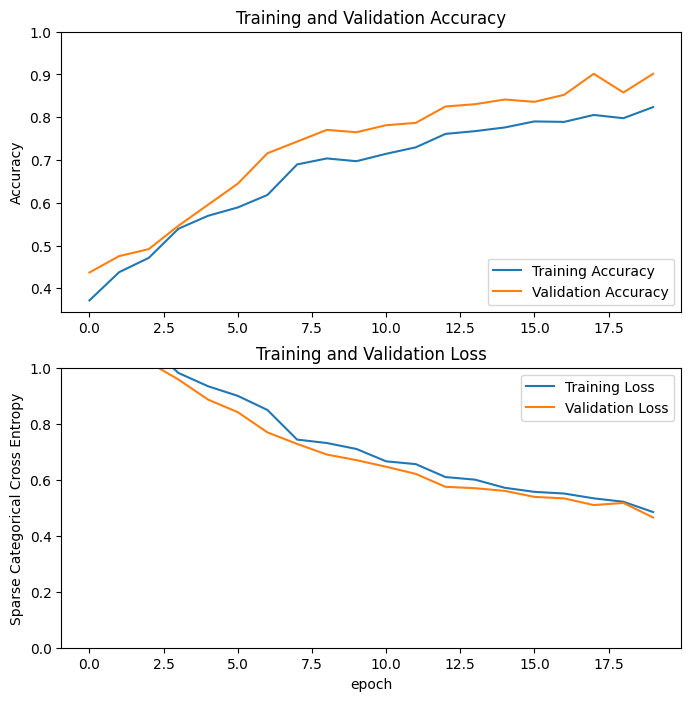

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Sparse Categorical Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Fine tuning

In [20]:
base_model.trainable = True

In [21]:
print("Number of layers in the base model: ", len(base_model.layers))

fine_tune_layers = 100

for layer in base_model.layers[:fine_tune_layers]:
  layer.trainable = False

Number of layers in the base model:  427


In [22]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate/10),
  loss="sparse_categorical_crossentropy",
  metrics=['accuracy']
)

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 lambda (Lambda)             (None, 224, 224, 3)       0         
                                                                 
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 3)                 3075      
                                                      

In [23]:
fine_tune_epochs = initial_epochs + 10

fine_tuned = model.fit(
    train_ds,
    epochs=fine_tune_epochs,
    initial_epoch=history.epoch[-1],
    validation_data=val_ds
)

Epoch 20/30
58/58 [==============================] - 123s 2s/step - loss: 0.5934 - accuracy: 0.7578 - val_loss: 0.3307 - val_accuracy: 0.9290
Epoch 21/30
58/58 [==============================] - 112s 2s/step - loss: 0.4164 - accuracy: 0.8324 - val_loss: 0.2571 - val_accuracy: 0.9344
Epoch 22/30
58/58 [==============================] - 107s 2s/step - loss: 0.3320 - accuracy: 0.8789 - val_loss: 0.2412 - val_accuracy: 0.9344
Epoch 23/30
58/58 [==============================] - 112s 2s/step - loss: 0.3130 - accuracy: 0.8800 - val_loss: 0.1895 - val_accuracy: 0.9563
Epoch 24/30
58/58 [==============================] - 107s 2s/step - loss: 0.2939 - accuracy: 0.8886 - val_loss: 0.1996 - val_accuracy: 0.9563
Epoch 25/30
58/58 [==============================] - 111s 2s/step - loss: 0.2397 - accuracy: 0.9200 - val_loss: 0.1983 - val_accuracy: 0.9508
Epoch 26/30
58/58 [==============================] - 111s 2s/step - loss: 0.2188 - accuracy: 0.9254 - val_loss: 0.1853 - val_accuracy: 0.9399
Epoch 

## Evaluate the model

In [24]:
acc += fine_tuned.history['accuracy']
val_acc += fine_tuned.history['val_accuracy']

loss += fine_tuned.history['loss']
val_loss += fine_tuned.history['val_loss']

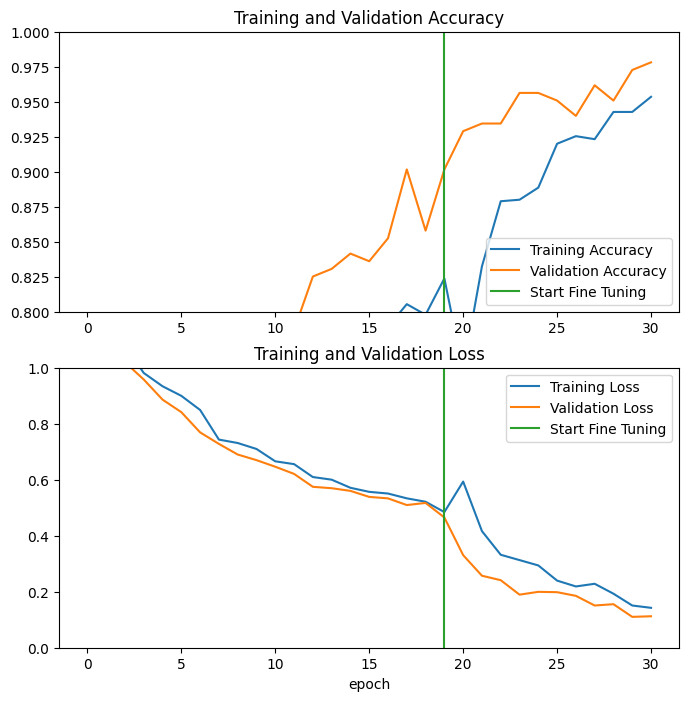

In [25]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Prediction

In [26]:
loss, accuracy = model.evaluate(test_ds)
print('Test accuracy :', accuracy)

3/3 [==============================] - 2s 621ms/step - loss: 0.0847 - accuracy: 1.0000
Test accuracy : 1.0


Predictions:
 [2 0 1 1 1 1 0 0 1 0 0 1 1 0 2 2]
Labels:
 [2 0 1 1 1 1 0 0 1 0 0 1 1 0 2 2]


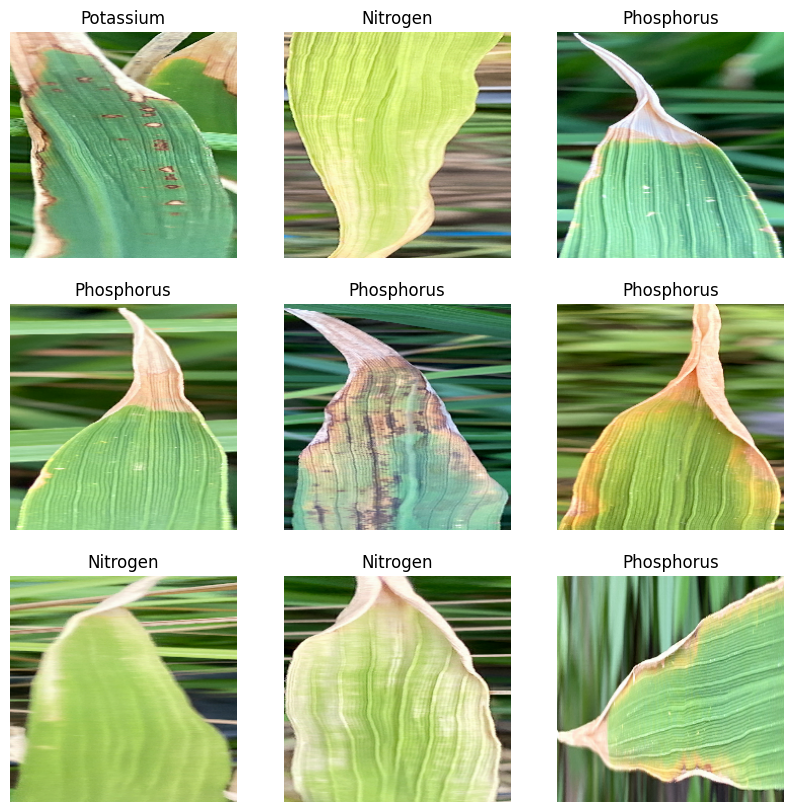

In [28]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_ds.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)

# Apply softmax activation to convert logits to probabilities
predictions = tf.nn.softmax(predictions)

# Convert probabilities to class labels
predicted_labels = np.argmax(predictions, axis=1)

print('Predictions:\n', predicted_labels)
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predicted_labels[i]])
  plt.axis("off")

plt.show()